In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold


In [2]:
import scanpy as sc

# read the full GSE dataset
# data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
# data = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE164378.h5ad")
data = sc.read_h5ad('/ws/Research_datasets/GSE164378/Hao_PBMC_GSE164378.h5ad')
data.shape

(161764, 33538)

In [3]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [4]:
data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


## Read features

In [5]:
# Level 1 ADlasso features by loss difference convergence
import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/feature_selection')
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\feature_selection")
os.chdir('/ws/GitHub/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [6]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,13,7
CD4_T,200,83
CD8_T,25,6
DC,25,15
Mono,21,11
NK,28,14
other,42,27
other_T,61,26


## Stratified K-fold

In [7]:
import pickle
import cupy as cp
import cudf
from cuml import train_test_split, SVC
from cuml.model_selection import StratifiedKFold
from cuml.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import average_precision_score, matthews_corrcoef

def SVM_strat_KFold_cuml(data, all_features_dict, celltype, k=5):
    # X = cp.sparse.csc_matrix(data[:, all_features_dict[celltype]['Gene'].tolist()].X)
    X = cudf.DataFrame(data[:, all_features_dict[celltype]['Gene'].tolist()].X.todense())
    y = cudf.Series([1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()])
    # print(X.shape)
    # print(y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    print('Fitting SVM model...')
    svm_clf = SVC(kernel='rbf', max_iter=5000)
    svm_clf.fit(X_train, y_train)

    print('Cross validation...')
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'pr_auc': [], 'mcc': []}
    
    kf_count = 1
    # for train_index, test_index in cv.split(cp.asnumpy(X_train), cp.asnumpy(y_train)):
    for train_index, test_index in cv.split(X_train, y_train):
        print('KF:', kf_count)
        # X_train_fold, X_test_fold = cp.asarray(X_train[train_index]), cp.asarray(X_train[test_index])
        # y_train_fold, y_test_fold = cp.asarray(y_train[train_index]), cp.asarray(y_train[test_index])
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        svm_clf.fit(X_train_fold, y_train_fold)
        y_pred = svm_clf.predict(X_test_fold)
        
        # Move y_test_fold and y_pred to CPU memory for sklearn metrics
        y_test_fold_cpu = cp.asnumpy(y_test_fold)
        y_pred_cpu = cp.asnumpy(y_pred)
        metrics['accuracy'].append(accuracy_score(y_test_fold_cpu, y_pred_cpu))
        metrics['precision'].append(precision_score(y_test_fold_cpu, y_pred_cpu))
        metrics['recall'].append(recall_score(y_test_fold_cpu, y_pred_cpu))
        metrics['f1'].append(f1_score(y_test_fold_cpu, y_pred_cpu))
        metrics['roc_auc'].append(roc_auc_score(y_test_fold_cpu, y_pred_cpu))
        metrics['pr_auc'].append(average_precision_score(y_test_fold_cpu, y_pred_cpu))
        metrics['mcc'].append(matthews_corrcoef(y_test_fold_cpu, y_pred_cpu))
        
        kf_count += 1

    mean_metrics = {metric: np.mean(values) for metric, values in metrics.items()}

    return svm_clf, mean_metrics

In [8]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/SVM_classifiers_all')
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\SVM_classifiers_all")
os.chdir('/ws/GitHub/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/SVM_classifiers_rbf_cuda')

all_metrics = []
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics_dict = SVM_strat_KFold_cuml(data, features_dict, celltype, k=5)  # metrics is a list
    print(metrics_dict)
    
    # Append metrics to all_metrics
    all_metrics.append(metrics_dict)

    # output SVM model as pickle
    filename = f'SVM_{celltype}_loss_diff_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: B
X train type: <class 'cudf.core.dataframe.DataFrame'>
Fitting SVM model...
Cross validation...
KF: 1
KF: 2
KF: 3
KF: 4
KF: 5
{'accuracy': 0.9994513672012187, 'precision': 0.9973701057828166, 'recall': 0.996195652173913, 'f1': 0.9967823568098393, 'roc_auc': 0.9979753315088529, 'pr_auc': 0.9939010640766959, 'mcc': 0.9964827863535826}
K-fold CV for: CD4_T
X train type: <class 'cudf.core.dataframe.DataFrame'>
Fitting SVM model...
Cross validation...
KF: 1
KF: 2
KF: 3
KF: 4
KF: 5
{'accuracy': 0.9687664189618659, 'precision': 0.9356023821036608, 'recall': 0.9415871502336423, 'f1': 0.9385834449862713, 'roc_auc': 0.9597906863851107, 'pr_auc': 0.8957563663631326, 'mcc': 0.917651927992916}
K-fold CV for: CD8_T
X train type: <class 'cudf.core.dataframe.DataFrame'>
Fitting SVM model...
Cross validation...
KF: 1
KF: 2
KF: 3
KF: 4
KF: 5
{'accuracy': 0.973526414626759, 'precision': 0.9089073290797615, 'recall': 0.924515337423313, 'f1': 0.9166429229709211, 'roc_auc': 0.953600056187714

In [9]:
all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df.index = types
all_metrics_df

,accuracy,precision,recall,f1,roc_auc,pr_auc,mcc
B,0.999451,0.997370,0.996196,0.996782,0.997975,0.993901,0.996483
CD4_T,0.968766,0.935602,0.941587,0.938583,0.959791,0.895756,0.917652
CD8_T,0.973526,0.908907,0.924515,0.916643,0.953600,0.852186,0.900956
DC,0.998370,0.965054,0.961336,0.963187,0.980273,0.928612,0.962357
Mono,0.992651,0.978799,0.997347,0.987986,0.993979,0.977007,0.982784
NK,0.992744,0.966345,0.970933,0.968630,0.983261,0.941610,0.964534
other,0.994846,0.982429,0.771592,0.864194,0.885646,0.762900,0.868218
other_T,0.989081,0.905267,0.826365,0.863952,0.911287,0.755370,0.859281


In [10]:
!pwd

/ws/GitHub/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/SVM_classifiers_rbf_cuda


In [11]:
all_metrics_df.to_csv('SVM_metrics_loss_diff_l1_AD_nostdscale_rbf_cuda.csv')

In [12]:
all_metrics_df.columns

Index(['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc', 'mcc'], dtype='object')

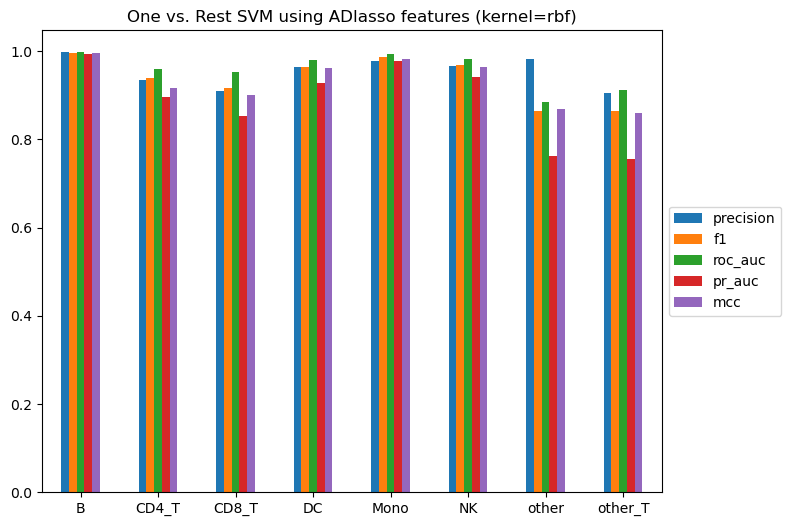

In [13]:
# Plot metrics for each celltype
cols = ['precision', 'f1', 'roc_auc', 'pr_auc', 'mcc']
ax = all_metrics_df[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest SVM using ADlasso features (kernel=rbf)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.tight_layout()
# plt.savefig('fig.png', bbox_inches='tight')

## L1 SVM Compare metrics: ADlasso - DEGn

In [7]:
# read metrics from ADlasso features
ad_svm_metrics = pd.read_csv(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\SVM_classifiers_rbf_cuda\SVM_metrics_loss_diff_l1_AD_nostdscale_rbf_cuda.csv", index_col=0)

# read metrics from DEGn
deg_svm_metrics = pd.read_csv(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\L1_DEG\L1_loss_diff_DEGn_SVM_rbf_metrics.csv", index_col=0)

ad_svm_metrics.columns = deg_svm_metrics.columns

In [8]:
ad_svm_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999451,0.997370,0.996196,0.996782,0.997975,0.993901,0.996483
CD4_T,0.968766,0.935602,0.941587,0.938583,0.959791,0.895756,0.917652
CD8_T,0.973526,0.908907,0.924515,0.916643,0.953600,0.852186,0.900956
DC,0.998370,0.965054,0.961336,0.963187,0.980273,0.928612,0.962357
Mono,0.992651,0.978799,0.997347,0.987986,0.993979,0.977007,0.982784
NK,0.992744,0.966345,0.970933,0.968630,0.983261,0.941610,0.964534
other,0.994846,0.982429,0.771592,0.864194,0.885646,0.762900,0.868218
other_T,0.989081,0.905267,0.826365,0.863952,0.911287,0.755370,0.859281


In [9]:
deg_svm_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999135,0.997089,0.992754,0.994916,0.996242,0.990482,0.994446
CD4_T,0.942569,0.882417,0.892317,0.887339,0.925974,0.814689,0.848827
CD8_T,0.969708,0.882626,0.931488,0.906399,0.954169,0.832944,0.888804
DC,0.997125,0.943262,0.926184,0.934645,0.962460,0.875273,0.933216
Mono,0.992798,0.978977,0.997654,0.988227,0.994170,0.977391,0.983131
NK,0.990912,0.957679,0.963836,0.960748,0.979140,0.927218,0.955615
other,0.993447,0.961240,0.720930,0.823920,0.860149,0.698922,0.829479
other_T,0.989862,0.920752,0.829897,0.872967,0.913384,0.771269,0.868972


In [10]:
metric_diff = ad_svm_metrics - deg_svm_metrics
metric_diff

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.000317,0.000281,0.003442,0.001866,0.001734,0.003419,0.002036
CD4_T,0.026197,0.053186,0.049270,0.051244,0.033817,0.081067,0.068825
CD8_T,0.003818,0.026281,-0.006973,0.010244,-0.000569,0.019242,0.012152
DC,0.001244,0.021792,0.035152,0.028542,0.017813,0.053340,0.029141
Mono,-0.000147,-0.000178,-0.000306,-0.000241,-0.000192,-0.000384,-0.000347
NK,0.001832,0.008666,0.007097,0.007883,0.004121,0.014392,0.008918
other,0.001399,0.021188,0.050662,0.040273,0.025497,0.063978,0.038739
other_T,-0.000780,-0.015484,-0.003532,-0.009015,-0.002097,-0.015899,-0.009690


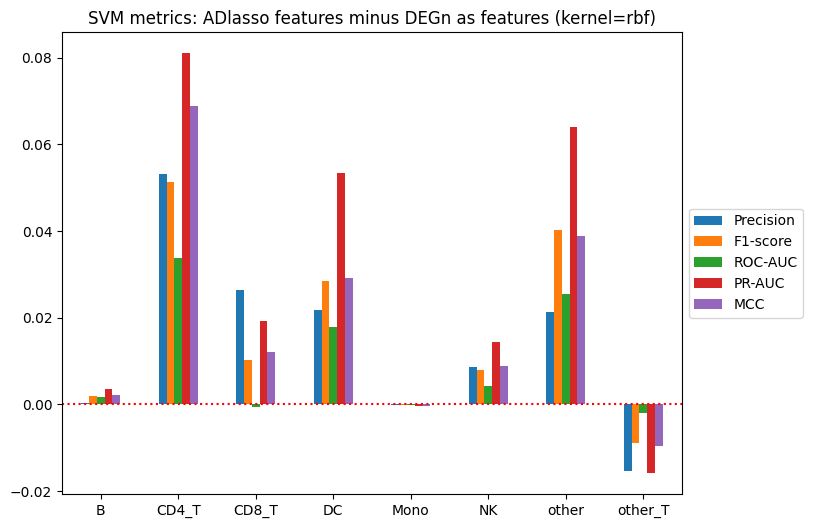

In [13]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = metric_diff[cols].plot.bar(rot=0, figsize=(8,6), title='SVM metrics: ADlasso features minus DEGn as features (kernel=rbf)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Add red dotted horizontal line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')
